This notebook was run in Google Colab in order to use NumPyro.

In [1]:
!wget https://data.nasa.gov/download/vjv9-9f3x/application%2Fzip -O mill.zip
!unzip mill.zip

--2023-05-01 12:10:05--  https://data.nasa.gov/download/vjv9-9f3x/application%2Fzip
Resolving data.nasa.gov (data.nasa.gov)... 128.102.186.77, 2001:4d0:6311:2c05:60b0:5ad8:1210:ea07
Connecting to data.nasa.gov (data.nasa.gov)|128.102.186.77|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.nasa.gov/api/views/vjv9-9f3x/files/d1c796e8-ca19-4b3d-804d-845e81c7cce3?filename=mill.zip [following]
--2023-05-01 12:10:06--  https://data.nasa.gov/api/views/vjv9-9f3x/files/d1c796e8-ca19-4b3d-804d-845e81c7cce3?filename=mill.zip
Reusing existing connection to data.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘mill.zip’

mill.zip                [       <=>          ]  14.44M  10.5MB/s    in 1.4s    

2023-05-01 12:10:08 (10.5 MB/s) - ‘mill.zip’ saved [15140674]

Archive:  mill.zip
  inflating: Readme.pdf              
  inflating: mill.mat                


In [3]:
!python -m pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 9.8 MB/s eta 0:00:00


In [12]:
import argparse
import time
from typing import Dict, Optional, Sequence, Tuple, Union

import jax
import jax.numpy as jnp
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.io import loadmat


def load_milling_data(file_path: str) -> Sequence[np.ndarray]:
    """Loads the milling data.

    Args:
        file_path: The path to the milling .mat file

    Returns:
        A list of numpy arrays of the run data.
    """
    data = loadmat(file_path)
    flank_wear = data["mill"]["VB"][0].astype(float)
    case_i = data["mill"]["case"][0].astype(int)
    case_wear = [flank_wear[case_i == i] for i in np.unique(case_i)]
    for i, x in enumerate(case_wear):
        idx = np.arange(x.shape[0])
        case_wear[i] = np.interp(idx, idx[~np.isnan(x)], x[~np.isnan(x)])
    return case_wear

def stepwise_model(
    sim_steps: int,
    a: np.ndarray,
    b: np.ndarray,
    k0: int = 0,
    x0: Optional[Union[np.ndarray, float]] = 0.0,
) -> jnp.ndarray:
    sim = jnp.zeros((a.shape[0], sim_steps))
    if x0 is not None:
        sim = sim.at[:, 0].set(x0)
    for i in range(sim_steps - 1):
        k = k0 + i
        rate = 0.4 * b * jnp.exp(0.4 * a * k)
        sim = sim.at[:, i + 1].set(sim[:, i] + rate.squeeze())
    if x0 is not None:
        sim = sim.at[:, 0].set(x0)
    return sim

def mcmc_model(data: np.ndarray, sigma: float) -> jnp.ndarray:
    """The model for MCMC.

    Args:
        data: The tensor of observations.
        sigma: The measurement noise.

    Returns:
        The sampled observation.
    """
    a = numpyro.sample("a", dist.Normal(0, 0.3))
    b = numpyro.sample("b", dist.HalfNormal(0.3))
    out = stepwise_model(data.shape[0], jnp.array([a]), jnp.array([b]))[0]

    return numpyro.sample("obs", dist.Normal(out, sigma), obs=data)

def compute_rsme_from_file(results_file: str) -> float:
    """Compute the RSME of the median prediction.

    Args:
        results_file: The path to the mcmc results file.
    
    Returns:
        The RSME.
    """
    results = np.load(results_file, allow_pickle=True).item()
    case_data = results["_data"]
    obs_len = results["_obs_len"]
    a_samples = results["a"]
    b_samples = results["b"]
    obs = case_data[:obs_len]
    all_sims = stepwise_model(
        case_data.shape[-1] - obs_len + 1,
        a_samples,
        b_samples,
        obs_len - 1,
        obs[obs_len - 1],
    )
    x = np.arange(all_sims.shape[-1]) + obs_len - 1

    # Compute the 90-10 interval for the prognosis
    top90 = np.quantile(all_sims, 0.9, axis=0)
    bottom10 = np.quantile(all_sims, 0.1, axis=0)
    median = np.quantile(all_sims, 0.5, axis=0)

    # Compute the RMSE
    rmse = np.sqrt(((case_data[obs_len:] - median[1:]) ** 2).mean()).item()

    return rmse
    

def plot_prognosis(
    case_data: np.ndarray, 
    obs_len: int, 
    a_samples: np.ndarray,
    b_samples: np.ndarray,
    title: str,
    ax: Optional[Axes] = None
) -> Figure:
    """Plot the prognosis.

    Args:
        case_data: The full tool wear degradation curve.
        obs_len: The length of the observation before prognosis.
        a_samples: The samples of model parameter a.
        b_samples: The samples of model parameter b.
        title: The title of the plot.
        ax: Optional, the axes to plot on.

    Returns:
        The Figure.
    """
    obs = case_data[:obs_len]
    all_sims = stepwise_model(
        case_data.shape[-1] - obs_len + 1,
        a_samples,
        b_samples,
        obs_len - 1,
        obs[obs_len - 1],
    )
    x = np.arange(all_sims.shape[-1]) + obs_len - 1

    # Compute the 90-10 interval for the prognosis
    top90 = np.quantile(all_sims, 0.9, axis=0)
    bottom10 = np.quantile(all_sims, 0.1, axis=0)
    median = np.quantile(all_sims, 0.5, axis=0)

    if ax is None:
        _, ax = plt.subplots(dpi=150)

    ax.plot(case_data, label="Actual", color="r", marker="o", markersize=2)
    ax.plot(
        x,
        top90,
        color="b",
        ls="--",
    )
    ax.plot(x, median, color="b", ls=":", label="Median")
    ax.plot(
        x,
        bottom10,
        color="b",
        ls="--",
    )
    ax.set_ylim(0, None)
    ax.set_xlim(0, case_data.shape[0] - 1)
    ax.set_xlabel("Run Index")
    ax.set_ylabel("Flank Wear (mm)")
    ax.set_xticks(np.arange(case_data.shape[0], step=4))
    ax.set_title(title)

def mcmc_main(
    milling_data: str,
    case_idx: int,
    obs_len: int,
    num_samples: int,
    out_file: Optional[str] = None,
    seed: int = 0
) -> Tuple[Dict[str, np.ndarray], float]:
    """MCMC inference on milling tool wear data.

    Args:
        milling_data: Path to the milling data .mat file.
        case_idx: The index of the milling case to use.
        obs_len: The length of the observation before prognosis.
        num_samples: The number of MCMC parameter samples after warmup.
        out_file: The output .pt file for saving MCMC samples.
        seed: The random seed.

    Returns:
        A tuple with the dictionary of results/samples
        and the elapsed perf_counter time.
    """
    data = load_milling_data(milling_data)

    case_data = data[case_idx]
    observed_data = case_data[:obs_len]

    nuts_kernel = NUTS(mcmc_model)
    mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=2000, num_chains=1)

    tic = time.perf_counter()
    # The args match those of the model function + a RNG seed
    mcmc.run(jax.random.PRNGKey(seed), observed_data, np.sqrt(0.002))
    toc = time.perf_counter()
    print(f"{toc - tic:.3f} s")

    mcmc.print_summary()

    samples: Optional[Dict[str, np.ndarray]] = mcmc.get_samples()
    assert samples is not None

    if out_file is not None:
        samples["_data"] = case_data
        samples["_obs_len"] = obs_len
        samples["_case_idx"] = case_idx
        jnp.save(out_file, samples)

    return samples, toc - tic


def show_mcmc_results(results_file: str, ax: Optional[Axes] = None):
    """Show the MCMC samples.

    Args:
        results_file: The .npy file of MCMC results.
        ax: Optional, the axes to plot on.
    """
    results = np.load(results_file, allow_pickle=True).item()
    case_data = results["_data"]

    plot_prognosis(
        case_data, 
        results["_obs_len"],
        results["a"], 
        results["b"], 
        f'Case {results["_case_idx"]+1}',
        ax
    )

In [14]:
for seed in range(5):
    for case_idx in [1, 10, 11]:
        _, _ = mcmc_main(
            "mill.mat", 
            case_idx=case_idx, 
            obs_len=10, 
            num_samples=10000, 
            out_file=f"case_{case_idx:02d}_seed_{seed:02d}.npy",
            seed=seed
        )

sample: 100%|██████████| 12000/12000 [00:10<00:00, 1157.84it/s, 11 steps of size 2.85e-01. acc. prob=0.92]


11.315 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.28      0.20     -0.28     -0.62      0.04   1856.51      1.00
         b      0.12      0.02      0.12      0.08      0.16   1908.99      1.00

Number of divergences: 0


sample: 100%|██████████| 12000/12000 [00:10<00:00, 1150.68it/s, 11 steps of size 3.08e-01. acc. prob=0.93]


10.968 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.12      0.24     -0.12     -0.52      0.28   2068.88      1.00
         b      0.06      0.02      0.05      0.03      0.08   2195.61      1.00

Number of divergences: 0


sample: 100%|██████████| 12000/12000 [00:10<00:00, 1118.25it/s, 15 steps of size 2.39e-01. acc. prob=0.93]


11.139 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.09      0.16      0.10     -0.17      0.37   2475.90      1.00
         b      0.08      0.02      0.08      0.05      0.11   2502.39      1.00

Number of divergences: 0


sample: 100%|██████████| 12000/12000 [00:10<00:00, 1115.44it/s, 7 steps of size 2.87e-01. acc. prob=0.92] 


11.120 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.20     -0.28     -0.61      0.04   2121.49      1.00
         b      0.12      0.02      0.12      0.08      0.16   2114.43      1.00

Number of divergences: 0


sample: 100%|██████████| 12000/12000 [00:10<00:00, 1123.05it/s, 9 steps of size 3.24e-01. acc. prob=0.93]


11.040 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.12      0.24     -0.11     -0.51      0.28   2089.47      1.00
         b      0.06      0.02      0.05      0.03      0.08   2189.24      1.00

Number of divergences: 0


sample: 100%|██████████| 12000/12000 [00:10<00:00, 1154.99it/s, 15 steps of size 1.99e-01. acc. prob=0.95]


10.762 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.09      0.17      0.10     -0.18      0.37   2123.22      1.00
         b      0.08      0.02      0.08      0.05      0.11   2159.86      1.00

Number of divergences: 0


sample: 100%|██████████| 12000/12000 [00:10<00:00, 1199.33it/s, 3 steps of size 2.72e-01. acc. prob=0.91] 


10.385 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.28      0.21     -0.27     -0.59      0.09   1704.14      1.00
         b      0.12      0.03      0.12      0.08      0.16   1707.31      1.00

Number of divergences: 0


sample: 100%|██████████| 12000/12000 [00:10<00:00, 1145.20it/s, 3 steps of size 3.04e-01. acc. prob=0.93]


11.060 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.11      0.25     -0.11     -0.51      0.31   1633.51      1.00
         b      0.06      0.02      0.05      0.03      0.08   1746.01      1.00

Number of divergences: 0


sample: 100%|██████████| 12000/12000 [00:12<00:00, 968.50it/s, 1 steps of size 2.96e-01. acc. prob=0.86] 


13.207 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.09      0.17      0.10     -0.19      0.35   1662.41      1.00
         b      0.08      0.02      0.08      0.05      0.11   1699.92      1.00

Number of divergences: 0


sample: 100%|██████████| 12000/12000 [00:10<00:00, 1094.05it/s, 3 steps of size 2.55e-01. acc. prob=0.92]


11.336 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.64      0.03   1883.39      1.00
         b      0.12      0.02      0.12      0.08      0.16   1898.78      1.00

Number of divergences: 0


sample: 100%|██████████| 12000/12000 [00:10<00:00, 1108.88it/s, 3 steps of size 3.42e-01. acc. prob=0.90]


11.193 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.12      0.24     -0.11     -0.50      0.30   2278.14      1.00
         b      0.06      0.02      0.05      0.03      0.08   2373.19      1.00

Number of divergences: 0


sample: 100%|██████████| 12000/12000 [00:11<00:00, 1087.21it/s, 3 steps of size 2.05e-01. acc. prob=0.94]


11.389 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.08      0.17      0.09     -0.19      0.36   2102.55      1.00
         b      0.08      0.02      0.08      0.05      0.11   2077.91      1.00

Number of divergences: 0


sample: 100%|██████████| 12000/12000 [00:10<00:00, 1119.27it/s, 15 steps of size 2.43e-01. acc. prob=0.94]


11.089 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.28      0.21     -0.27     -0.62      0.06   1955.72      1.00
         b      0.12      0.03      0.12      0.08      0.16   2034.67      1.00

Number of divergences: 0


sample: 100%|██████████| 12000/12000 [00:10<00:00, 1119.26it/s, 15 steps of size 3.02e-01. acc. prob=0.94]


11.077 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.11      0.24     -0.11     -0.51      0.27   1872.21      1.00
         b      0.06      0.02      0.05      0.03      0.08   1916.14      1.00

Number of divergences: 0


sample: 100%|██████████| 12000/12000 [00:10<00:00, 1150.22it/s, 15 steps of size 2.13e-01. acc. prob=0.94]


10.829 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.10      0.16      0.10     -0.18      0.36   1686.07      1.00
         b      0.08      0.02      0.08      0.05      0.11   1736.41      1.00

Number of divergences: 0


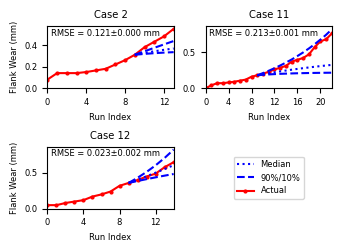

In [16]:
plt.rc("font", size=6.0)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(3.4, 2.5))
axs = [ax for row in axs for ax in row]
rmse = [
    [
        compute_rsme_from_file(f"case_{idx:02d}_seed_{i:02d}.npy")
        for i in range(5)
    ]
    for idx in [1, 10, 11]
]

for i, idx in enumerate([1, 10, 11]):
    show_mcmc_results(f"case_{idx:02d}_seed_00.npy", axs[i])
    mean_rmse = np.mean(rmse[i])
    std_rmse = np.std(rmse[i])
    axs[i].text(
        0.03, 
        0.85, 
        f"RMSE = {mean_rmse:.3f}±{std_rmse:.3f} mm", 
        transform=axs[i].transAxes
    )

axs[1].set_ylabel("")
axs[3].axis("off")
artists = [
    plt.Line2D([], [], color="b", ls=":", label="Median"),
    plt.Line2D([], [], color="b", ls="--", label="90%/10%"),
    plt.Line2D([], [], color="r", ls="-", marker="o", markersize=2, label="Actual"),
]
plt.legend(handles=artists, loc="center")
fig.tight_layout()
plt.savefig("out.pdf", bbox_inches="tight")
plt.show()

In [ ]:
times = []
for _ in range(25):
    _, elapsed = mcmc_main(
        "mill.mat", 
        case_idx=1, 
        obs_len=10, 
        num_samples=10000, 
        out_file=f"case_{case_idx:02d}.npy"
    )
    times.append(elapsed)
print(f"{np.mean(times):.3f}+/-{np.std(times):.3f} s")